# PSPG 245B CDD Workshop - Simple Neural Network Classifier Example

This notebook is primarily a tutorial on how to train a neural network, with fewer fill-in-the-blank sections than the previous notebooks. Carefully read through the sections, follow the directions, and answer all questions.

In the previous notebook, we trained a Naive Bayes classifier on our data predict binding. However, this is a relatively simple model. Could we instead use a neural network to improve our accuracy?

Machine learning (ML) involves using computational methods to learn from the data without any explicit programming. ML is being used in nearly all the fields of science and has made important and notable breakthroughs. Deep learning is a subfield of ML and is concerned with algorithms which loosely mimic the human brain and are called deep neural networks (DNNs). A classical application of ML is in image classification where the model tries to associate a label to each image using the features in the pixel data. The underlying idea is that there is a explicit relation between the set of pixels and the associated label which the model tries to learn. The same idea can be extended to the molecular space where a full description of atomic or molecular features dictates its chemical properties. 

Supervised learning: In supervised learning, the model is provided with the inputs and the labels for all input samples and the task is usually finding the desired properties (labels) of any given input. The model after proper training is able to predict the target (label) of unseen samples. Most common supervised learning tasks are regression and classification tasks.

Unsupervised Learning: Unlike supervised learning in unsupervised learning the data will not contain labels and the task is to identify patterns or similarities/differences within the data. Clustering for example is an unsupervised learning problem. Methods such as K-means clustering fall in this category. Another important task in unsupervised learning is dimensionality reduction where the goal is to find a reduced dimension of the data that carries most of the important or relevant information.

The structure of analytic neural networks is inspired by neural connections in the brain. Neural networks consist of multiple layers of simpler units. A "perceptron" is the simplest neural network with a single layer. In a perceptron, the model takes single or multiple inputs and computes a weighted sum of the input and finally applies a non-linear activation function to compute a single output.

![img](https://www.simplilearn.com/ice9/free_resources_article_thumb/Perceptron/general-diagram-of-perceptron-for-supervised-learning_4.jpg)

\begin{equation}
    y = f(\sum_i x_i w_i + b)
\end{equation}

In the above equation 𝑥𝑖
 are inputs, 𝑤𝑖
 are the weights and 𝑏
 is a bias term. 𝑓
 is a nonlinearity function. The nonlinearity is also called activation function. There are many different activation functions that are commonly used in machine learning such as ReLU, tanh, Sigmoid and can be used depending on the task and the type of network.
 
 A Feed-forward Neural network (FFNN)is a collection of multiple perceptrons stacked together. A FFNN is also called a multi-layer perceptron (MLP). Universal approximation theorem states that a MLP containing as little as one hidden layer with a finite number of neurons can approximate any continuous function under mild assumptions on the activation functions used.
 
 ![img](https://www.researchgate.net/publication/325398785/figure/fig1/AS:631270266642432@1527517968135/A-feedforward-multilayer-perceptron-architecture-15-function-which-is-a-mathematical.png)
 
 Cost functions: Training a neural network involves minimizing a loss or cost function which usually measures the discrepancy between actual values and the values that are output of the network. Some types of cost functions are mean squared error or a categorical cross entropy loss for classification tasks.
 
 **Backward propagation**  During training a deep neural network, we need to update the weights and biases of the network $(w,b)$. The question remains how to compute the gradient of loss function $\Gamma$ with respect to the parameters of the inner layers on the network. This is done by backpropagation algorithm where a chain rule is used to compute gradient of inner layers. In this approach, we calculate numerically the derivative of the cost function with respect to weight $w_{ij}$ in layer $l$ using a chain rule. The derivative of the loss $\Gamma$ is taken with respect to the net input to outer node $u_i$, then using chain rule with respect to parameters we want to optimize.
 
 **gradient descent** Once we have the gradients of the loss with respect to model parameters we can minimize the loss. If $\theta$ denotes all the parameters of the neural network, given the initial parameters of the network, the most basic gradient descent scheme updates them as:
 
 
\begin{equation}
    \theta_{k+1} = \theta_k -\eta \nabla_{\theta_k} \Gamma (\theta_k)
\end{equation}

Where $\eta$ is the learning rate, controls the size of the step for training. This is considered a hyperparameter during training.  The minus sign in the equation ensures the parameters are updated to minimize the loss. Other variants of gradient descent algorithm are proposed such as stochastic gradient descent (SGD) where at each epoch of training a mini-batch of data is used for error computation. Other types include Adam optimization and RMSProp which are variants of SGD using momentum techniques to speed up the training and avoid getting stuck in local minima.

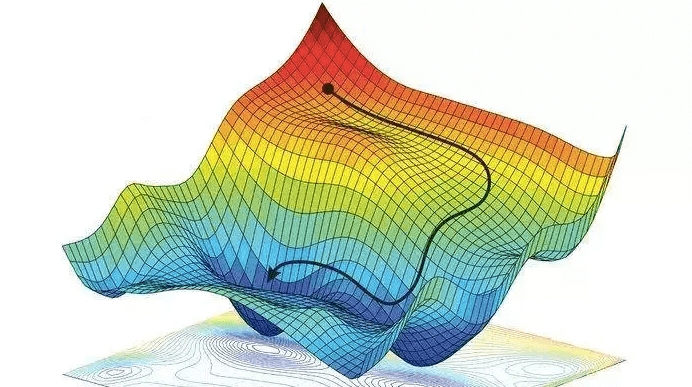


### Imports

In [4]:
# I/O tools
import os,sys, operator
import gzip
import csv
import warnings

import numpy as np # classific numerical computing library
from tqdm import tqdm # progress tracking

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# analysis
from sklearn.metrics import confusion_matrix

# pytorch
import torch
from torch.utils.data import Dataset, DataLoader

# Chemical Handling Modules
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw

# utils
from utils import map_target_identifiers, flatten_list, view_target_dist, format_training_data

# 1. Read in our training data from .tar.gz files

The utility function to do this has already been written, imported from utils.py, and we already used it for our NB classifier. We just need to pass in the correct file paths:

In [5]:
BASE_DIR = os.getcwd()

CANCER_CPDS_F = os.path.join(BASE_DIR, 'data', 'cancer_compounds.sample.csv')
CHEMBL_MOLS_F = os.path.join(BASE_DIR, 'data', 'chembl_21_binding_molecules.csv.gz')
CHEMBL_TARGS_F = os.path.join(BASE_DIR, 'data', 'chembl_21_binding_targets.csv.gz')

In [6]:
all_data, all_classes = format_training_data(CHEMBL_MOLS_F, CHEMBL_TARGS_F)

Formatting training data for use with Naive Bayesian Classifier...
	Transforming cpd smiles to bit-vectors from file: chembl_21_binding_molecules.csv.gz
		Generated 334291 compound bit-vectors
	Mapping target classes to compound bit-vectors from file: chembl_21_binding_targets.csv.gz
		Generated 1372818 total training examples.



## 2. Format our data for training
Unlike the NB classifier from scikit-learn, training a neural network involves a bit more data wrangling. Pytorch expects "tensors" created by a DataLoader and numeric labels that hve been one-hot encoded. This means that instead of a single element label for each target, the label is instead an array of size n_dimensions, where all positions except the index corresponding to the label are 0.

As a toy example, this demonstrates the one-hot encoding for 3 color labels:
![img](https://i.imgur.com/mtimFxh.png)

Our 1-hot receptor encoding is large, but not too unreasonable.

For an map-style dataset, there are 3 major functions we need to implement.
1. \_\_init__: constructor function, sets up data structures and one-hot encodes labels
2. \_\_getitem__: returns (feature, label) pair corresponding to requested index
3. \_\_len__: size of the dataset, used to determine when each training epoch has finished


In [7]:
## DO NOT ALTER ##
class FingerprintDataset:
    def __init__(self, X_data, y_data = None, y_labels = None, downsample=True): # creation function
        self.X_data = X_data
        self.y_data = None
        if y_data is not None:
            # one-hot encode receptors
            y_map = dict((label, i) for i, label in enumerate(y_labels))
            y_indices =  np.array([y_map[y] for y in y_data])
            self.y_data = np.zeros((len(y_data), len(y_map)))
            self.y_data[np.arange(y_indices.size), y_indices] = 1
            
        if downsample: # on by default, turn off for final model training!
            n = X_data.shape[0]
            sample_idx = np.random.randint(n, size=int(0.01*n))
            self.X_data = self.X_data[sample_idx]
            if self.y_data is not None:
                self.y_data = self.y_data[sample_idx]
    
    def __getitem__(self, idx): # what to return when a specific index of our dataset is requested
        if self.y_data is not None:
            return self.X_data[idx].astype(np.float32), self.y_data[idx].astype(np.float32)
        else: return self.X_data[idx]
        
    def __len__(self): # how many examples are in our dataset?
        return self.X_data.shape[0]

In [8]:
sorted_protein_labels = sorted(list(set(all_classes)))

In [9]:
chembl_dataset = FingerprintDataset(all_data, all_classes, y_labels = sorted_protein_labels)

### *Question: How can we get the number of examples in our dataset?*

### Pass our dataset to a dataloader:
Together with the dataset object, Pytorch also has a DataLoader class that handles batch loading (allowing us to pass multiple examples through the model at once) and shuffling, which is good practive for model training. The following cell creates a DataLoader using our Fingerprint dataset that shuffles the data and loads it in batchs of 256.

In [10]:
chembl_dataloader = DataLoader(chembl_dataset,
                                shuffle = True,
                                batch_size = 256) # How many batches will be in a single epoch?

In [11]:
## FILL IN THE BLANKS ##
X_batch, y_batch = next(iter(chembl_dataloader))
assert X_batch.shape[0] == ? # What should this equal?
assert X_batch.shape[1] == ? # What should this equal?

SyntaxError: invalid syntax (<ipython-input-11-f77e73040465>, line 3)

### Data splitting
In the previous notebook, we split our data into 2 groups, training and testing. In contrast, typically when training a neural network, we want to split our data into *3* groups:
1. Training - What the model uses to update its weights
2. Validation - Plotted alongside the training loss, used to check for overfitting and select the best set of <i>hyperparameters</i>
3. Testing - Unseen by the model, used to report final model accuracy.

The proportion of data used for each of these is a design choice, but 80/10/10 is a good rule of thumb.

Often, these are designed to minimize data leakage (for example, splitting by molecular scaffold such that certain molecular scaffolds only appear in the training or testing set, but never both), but for now we will just do a random split.

In [ ]:
## DO NOT ALTER ##
def random_split(num_examples):
    indices = np.array(list(range(num_examples))) 
    np.random.seed(27) # reproducible behavior
    np.random.shuffle(indices) # shuffle examples
    train_indices = indices[:int(.8*len(indices))] # 1st 80% go to train
    val_indices = indices[int(.8*len(indices)):int(.9*len(indices))] # 10% to validation
    test_indices = indices[int(.9*len(indices)):] #10% to test
    
    return train_indices, val_indices, test_indices

In [ ]:
train_idx, val_idx, test_idx = random_split(all_data.shape[0])

Now we create our training and testing dataloaders. Note that these both have downsample set to True, which means only 1% of the data will be used. This is useful for prototyping models, but for the final model you will want to set that flag to False and train on the entire dataset.

In [ ]:
train_dataloader = DataLoader(FingerprintDataset(all_data[train_idx], all_classes[train_idx],
                                                y_labels = sorted_protein_labels,
                                                downsample = True),
                              shuffle = True, batch_size = 256) # shuffle training set
val_dataloader = DataLoader(FingerprintDataset(all_data[val_idx], all_classes[val_idx],
                                                y_labels = sorted_protein_labels,
                                               downsample=True),
                              shuffle = False, batch_size = 256) # Don't need to shuffle validation

## 3. Set up our model

Now that we have our training data in a way that Pytorch expects, we can define our model and start training. The class below defines a simple feed-forward network, or in other words, all nodes in layer n are connected to all nodes in layer n+1. 

By default, it takes a 1024-dimensional input and produces a 2240-dimensional output.


### *Question: Where did we get those default dimensions? What will the dimension of the model output be?*

In [ ]:
## DO NOT ALTER ##
class FFModel(torch.nn.Module):
    def __init__(self, layers=[1024, 2048, 2048, 2240]):
        super(FFModel, self).__init__()

        seqs = []
        for i in range(len(layers)-1):
            seqs.append(torch.nn.Linear(layers[i], layers[i+1])) # define weight matrices
            if i < len(layers) - 2:
                seqs.append(torch.nn.ReLU()) #relu activation
        
        self.net = torch.nn.Sequential(*seqs) # apply sequentially
        
    def forward(self, x):
        return self.net(x)        
            

## 4. Training loop 

The below function trains our neural network and reports both the training and validation loss. We are using an Adam optimizer (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) with a learning rate of 1e-4.

This function first creates the network and passes it to the optimizer, which allows to optimizer to update the model weights based on the loss. It then performs training for a maximum of 100 epochs. At each epoch, each batch from the dataloader is passed through the model, the loss (error) is calculated, and the weights are updated by the optimizer to minimize the loss. 

After this process, the validation loss is calculated in order to ensure our model isn't *overfitting*, or simply memorizing the training data in a way that fails to generalize to new inputs. We check that the validation loss has decreased and checkpoint the model if it has. If the validation fails to decrease within our specified number of epochs ("patience" parameter), we stop training. This is called "early stopping".

The number of layers, number of neurons, optimizer, learning rate, patience, activation function, and many more are what are refered to as "hyperparameters". This is to differentiate themselves from the model parameters, which are learned during training. A model's success often depends on the hyperparameters which are set before model training by the researcher. There are libraries such as Optuna (https://optuna.org/) and Hyperopt (http://hyperopt.github.io/hyperopt/) that will test multiple hyperparameter combinations and attempt to find the best set for a given model/dataset, but for now we've set the defaults for you.


In [ ]:
## DO NOT ALTER ##
def train_model(layers, train_dataloader, val_dataloader, 
                learning_rate = 1e-4, 
                max_epochs = 100, 
                patience = 3, 
                verbose = True):
    # Setup objects
    model = FFModel(layers) # Model
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate) # Optimizer - updates the weights
    loss_function = torch.nn.BCEWithLogitsLoss() # Loss Function - We're using Binary Cross Entropy with Logits
    
    best_validation = float("inf")
    patience_count = 0
    
    all_losses = [[],[]]
    for epoch in range(max_epochs):
        train_losses = []
        val_losses = []
        # Train for an epoch:
        for features, labels in tqdm(train_dataloader): # iterate through all our training examples
            optim.zero_grad() 
            
            # get the loss - how far were our predicted values from our actual values?
            loss = loss_function(model(features), labels) 
            
            # update the model weights to minimize the loss
            loss.backward()
            train_losses.append(loss.item())
            optim.step()
            
        train_loss = np.mean(train_losses)
        all_losses[0].append(train_loss)
        # Now we run validation
        with torch.no_grad(): # we don't want to update the model during this
            for features, labels in val_dataloader:
                loss = loss_function(model(features), labels)
                val_losses.append(loss.item())
        val_loss = np.mean(val_losses)
        all_losses[1].append(val_loss)
        
        if verbose:
            print(f"Epoch {epoch} - Train: {train_loss:.5f}, Validation: {val_loss:.5f}")
        if val_loss < best_validation:
            best_validation = val_loss
            patience_count = 0
            # save model checkpoint
            torch.save(model, 'checkpoint.pt')
        else:
            patience_count += 1
            if patience_count > patience:
                if verbose:
                    print(f"Early stopping triggered at epoch {epoch}, stopping...")
                    break
    
    return all_losses 

In [ ]:
layers = [1024, 2048, 2048, len(sorted_protein_labels )] # define our model size

In [ ]:
# Train our model. This takes a LONG time, especially on the full dataet (no downsampling) 
# For reference, it took 32 epochs of ~10 minutes each to converge using a patience of 10.
losses = train_model(layers, train_dataloader, val_dataloader) 

### Plot our losses
Typically one sanity-check in deep learning is to ensure that the loss curves look "reasonable". We can determine this after the model has completed training by plotting both the validation and training loss curves.

### *Question: Based on the above discussion, what would overfitting look like in the loss curve plot?*

In [ ]:
for loss, label in zip(losses, ["Training", "Validation"]):
    plt.plot(loss, label=label)
plt.legend()

## 5. Using our trained model

Now that we have trained our model, we want to evaluate it on the test set to determine the performance. Similar to NB, we need to generate the test predictions, plot the confusion matrix, and calculate overall accuracy.

In [ ]:
trained_model = torch.load("checkpoint.pt") # load trained model from final checkpoint, you may have to update the file name
test_dataloader =  DataLoader(FingerprintDataset(all_data[test_idx], all_classes[test_idx],
                                                y_labels = sorted_protein_labels,
                                                downsample = False), # downsample for a faster evaluation
                              shuffle = False, batch_size = 256)

In [ ]:
## DO NOT ALTER ##
### get test predictions
def get_predictions(model, dataloader, label_names = None):
    true_labels = []
    predicted_labels = []
    for features, labels in dataloader:
        true_labels.append(labels.numpy())
        predicted_labels.append(trained_model(features).detach().numpy())
    true_labels = np.argmax(np.concatenate(true_labels), axis=1)
    predicted_labels = np.argmax(np.concatenate(predicted_labels), axis=1)
    
    if label_names is not None:
        true_labels = np.array(label_names)[true_labels]
        predicted_labels = np.array(label_names)[predicted_labels]
    return true_labels, predicted_labels
    

In [ ]:
testing_labels, testing_preds = get_predictions(trained_model, test_dataloader, label_names = sorted_protein_labels)
accuracy = sum(testing_labels == testing_preds)/testing_labels.shape[0]

ax = plt.axes()
sns.heatmap(confusion_matrix(testing_labels, testing_preds), ax = ax) # plotting
ax.set_title(f'Accuracy: {accuracy:.3f}')
plt.savefig("NN_training_set_heatmap.png")
plt.show()

## Finally: Apply to cancer targets

Using the same compounds of interest from before, now we can calculate the Neural Network predictions.

In [ ]:
## DO NOT ALTER 
def gen_compound_bitstring(smile, radius=4, nBits=1024):
    """ Generate morgan-fingerprint from compound smile, convert fingerprint to bit-vec"""
    mol = Chem.MolFromSmiles(smile) # convert the smiles to RDKit mol object
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits) # find the morgan fingerprint of the molecule at radius and nBits
    bstr = fp.ToBitString()
    return bstr

def predict_top_targets_for_compounds(cpd_f, model, targID_to_targName, ntop=10, verbose=True, classes=[]):
    """Load compounds of interest, convert to fp, get top N target predictions for each compound,
    and write to file."""
    base_dir = os.path.dirname(cpd_f)
    base_name = os.path.basename(cpd_f).split('.csv')[0]
    res_ofn = os.path.join(base_dir, base_name+'.predictions.NN.csv')
    header = ['Zinc_ID', 'Targ_ID', 'Targ_Class', 'Probability_Estimate', 'Drug_Name', 'Smile']
    
    # Initiate csv reader and writer
    #with open(cpd_f, 'r') as fi, open(res_ofn, 'w') as fo:
    fi, fo = (open(cpd_f, 'rt'), open(res_ofn, 'w'))
    reader = csv.reader(fi)
    next(reader)
    writer = csv.writer(fo)
    writer.writerow(header)
    # Iterate through cpd_f, generate compound bit-vectors
    for cpid, smile, drugname in reader:
        bstr = gen_compound_bitstring(smile)
        if bstr is None:
            continue
        temp = np.frombuffer(bstr.encode(), 'i1') - 48
        bitVec = temp.reshape(1, -1)
        
        # Generate array of probabilites for bitVec belonging to each target class
        probabilities = model(torch.from_numpy(bitVec).type(torch.FloatTensor)).detach().numpy() # swaped to use model, take tensor as input
        target_probs = zip(classes, probabilities)
        
        # Sort by most relevant targets, and write top N targets associated with bitVec to file
        top_targs = sorted(target_probs, key=operator.itemgetter(1), reverse=True)
        if verbose:
            toprint = [(targID_to_targName[targID], prob) for targID,prob in top_targs[0:ntop]]
            print('{}: '.format(cpid), toprint)
            print('')
        for targID, prob in top_targs[0:ntop]:
            writer.writerow([cpid, targID, targID_to_targName[targID], prob, drugname, smile])
    return res_ofn

In [ ]:
def predict_targets(cancer_cpds_f, chembl_targ_f, trained_model, ntop=5, verbose=False, classes=[]):
    """Maps targets, formats data, trains a naive bayesian classifier, then predicts and plots top targets, 
    based on cancer-related compounds file provided"""
    chid_to_targName = map_target_identifiers(chembl_targ_f)
    preds_f = predict_top_targets_for_compounds(cancer_cpds_f, trained_model, chid_to_targName, ntop=ntop, 
                                                verbose=verbose,
                                               classes=classes)
    view_target_dist(preds_f, figsize=(18,12), suffix='NN')
    return preds_f

In [ ]:
predict_targets(CANCER_CPDS_F, CHEMBL_TARGS_F, trained_model, classes=sorted_protein_labels)

### *Question: Do the same targets appear for both methods? Are the distribution of the most frequently predicted targets similar between Naive Bayes and Neural Networks?*

### *Exercise: Repeat training with modified hyperparameters (layers, learning rate, batch size in data loaders). What parameters did you test? Were the accuracies significantly different? How about the frequently predicted targets? Write a summary of what you tried and how it affected training (loss curves, accuracy). Train at least 3 different models.*

## Further Reading

### - Graph Neural Networks 

Graphs are an alternative way to represent molecules. Mathematically, a graph $G$ is defined as a tuple of a set of nodes/vertices V and set oedges/links E: $G=(V,E)$. each edge is a pair of two vertices and represents a connection between them.

**Adjacency matrix A** is a square matrix whose elements indicate whether pairs of vertices are adjacent i.e. connected or not. for example for the following graph the adjacency matrix is :

$A=\begin{bmatrix}
0 & 1 & 0 & 0 \\
1 & 0 & 1 & 1 \\
0 & 1 & 0 & 1 \\
0 & 1 & 1 & 0 
\end{bmatrix}$

![img](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/example_graph.svg)


#### Graph convolutions

Many data can be represented as graph data structure such as the structure of molecules, proteins or social networks. Graph neural networks are increasingly being used in many areas such as protein structure prediction, drug design, etc. A graph $G$ is defined as $G=(V,E,A)$ where V is the set of nodes, E is the set of edges and A is the adjacency matrix. Graph convolutional networks rely on message passing between neighbors in a graph. Each node has a feature vectors that represents its message and messages are passed between neighbors during each graph convolution layer or message passing. Multiple types of GCN can be formulated based on how the messaged are passed between nodes and edges. In a simple GCN, where only nodes have feature vectors, the GCN layer can be defined as:


\begin{equation}
    H^{l+1} = \sigma ( \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2} H^{(l)} W^{(l)})
\end{equation}

where $H^{(l)}$ is the features of previous nodes, $W^{(l)}$ is the weight parameters. $\hat{A}$ is the adjacency with including self connections. $\hat{A}=A+I$. The messages are averaged over neighbors using the matrix $\hat{D}$ which is the diagonal matrix, where $D_{ii}$ is the number of connections of node $i$ and $\sigma$ denotes a nonlinear activation function.  

![img](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/graph_message_passing.svg)

A simple implementation of GCN in pytorch is as follows:

In [ ]:
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = torch.nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [ ]:
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Apply a simple GCN layer the graph we defined:

In [ ]:
layer = GCNLayer(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Graph neural network can be used for different task on molecular dataset. These include but are not limited to classification, regression, molecular generation and graph completion. You can read more about graph neural networks at [here](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html).